In [8]:
# Imports 
import os
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

os.environ["pyna_language"] = 'python'
from pyNA.pyna import pyna

In [9]:
# Inputs 
z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444

ipnlt_constraint = dict()
ipnlt_constraint['stca'] = 94.7
ipnlt_constraint['a10'] = np.nan

ipnlt_constraint_lst = np.array([94.70693028, 93.35837504]) + 0.25
k_lst = [1.2, 1.4]

In [10]:
def plot_stcb_design_sweep(ac_name, z_cb_lst, TS_cb_lst, epnl_lateral, epnl_flyover, epnl_lateral_pr, epnl_flyover_pr): 

    fig, ax = plt.subplots(1,3,figsize=(20,4), sharey=True, dpi=100)
    plt.style.use('../utils/plot.mplstyle')
    fontsize=16
    
    lev_min = np.floor(np.min((np.min(epnl_lateral), np.min(epnl_flyover), np.min(epnl_lateral_pr), np.min(epnl_flyover_pr))))
    lev_max = np.ceil(np.max((np.max(epnl_lateral), np.max(epnl_flyover), np.max(epnl_lateral_pr), np.max(epnl_flyover_pr))))
    
    if ac_name == 'stca':
        levels=np.arange(lev_min, lev_max+1, 0.5)
    elif ac_name == 'a10':
        levels=np.arange(lev_min, lev_max+1, 0.5)

    ax[0].contour(TS_cb_lst, z_cb_lst, epnl_lateral, levels=levels, colors='k', linewidths=0.5, alpha=0.5)
    C0 = ax[0].contourf(TS_cb_lst, z_cb_lst, epnl_lateral, cmap='magma', levels=levels)
    cbar0 = plt.colorbar(C0, ax=ax[0])
    if ac_name == 'stca':
        cbar0.set_ticks(np.arange(lev_min, lev_max+1, 2))
    else:
        cbar0.set_ticks(np.arange(lev_min, lev_max+1, 1))
    cbar0.ax.tick_params()
    ax[0].set_title(r'$EPNL_{lateral}$ [EPNdB]', pad=10)
    ax[0].set_ylabel('$z_{cb}\ [m]$')
    
    ax[1].contour(TS_cb_lst, z_cb_lst, epnl_flyover, levels=levels, colors='k', linewidths=0.5, alpha=0.5)
    C1 = ax[1].contourf(TS_cb_lst, z_cb_lst, epnl_flyover, levels=levels, cmap='magma')
    cbar1 = plt.colorbar(C1, ax=ax[1])
    cbar1.ax.tick_params()
    if ac_name == 'stca':
        cbar1.set_ticks(np.arange(lev_min, lev_max+1, 2))
    else:
        cbar1.set_ticks(np.arange(lev_min, lev_max+1, 1))
    ax[1].set_title(r'$EPNL_{flyover}$ [EPNdB]', pad=10)

    epnl_total = epnl_lateral + epnl_flyover
    epnl_total_pr = epnl_lateral_pr + epnl_flyover_pr
    lev_min = np.floor(np.min((np.min(epnl_total), np.min(epnl_total_pr))))
    lev_max = np.ceil(np.max((np.max(epnl_total), np.max(epnl_total_pr))))

    if ac_name == 'stca':
        levels=np.arange(lev_min, lev_max+1, 0.5)
    elif ac_name == 'a10':
        levels=np.arange(lev_min, lev_max+1, 0.5)
    ax[2].contour(TS_cb_lst, z_cb_lst, epnl_total, levels=levels, colors='k', linewidths=0.5, alpha=0.5)
    C2 = ax[2].contourf(TS_cb_lst, z_cb_lst, epnl_total, levels=levels, cmap='magma')
    cbar2 = plt.colorbar(C2, ax=ax[2])
    cbar2.ax.tick_params()
    if ac_name == 'stca':
        cbar2.set_ticks(np.arange(lev_min, lev_max+1, 2))
    else:
        cbar2.set_ticks(np.arange(lev_min, lev_max+1, 1))
    ax[2].set_title(r'$EPNL_{take-off}$ [EPNdB]', pad=10)

    i_base1 = np.unravel_index(np.argmin(epnl_flyover, axis=None), epnl_total.shape)
    i_base2 = np.unravel_index(np.argmin(epnl_total[:10,:], axis=None), epnl_total.shape)
    
    for i in np.arange(3):
        ax[i].set_xlim([0.30, 1.0])
        ax[i].set_xlabel('$TS_{cb}\ [-]$')
        ax[i].tick_params(axis='both')
        ax[i].set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax[i].set_yticks([25, 250, 500, 750])
        ax[i].fill_between([0.30, TS_cb_lst[0]], [25,25], [750,750], facecolor='w', hatch='/')
        ax[i].plot([TS_cb_lst[i_base1[1]]], [z_cb_lst[i_base1[0]]], '*', markerfacecolor='w', markeredgecolor='grey', markersize=20)
        ax[i].plot([TS_cb_lst[i_base2[1]]], [z_cb_lst[i_base2[0]]], '*', markerfacecolor='w', markeredgecolor='grey', markersize=20)
        
        if ac_name == 'stca':
            ax[i].plot([0.3, 1.0], [260, 260], 'k--', linewidth=1.5) 
            ax[i].annotate(r"$z_{cb} > 260 m \uparrow$", xy=(0.33, 295), fontsize=fontsize, color='k', bbox=dict(facecolor='w', edgecolor='w', alpha=0.9))
            # ax[i].annotate("", xy=(0.4, 345), xycoords='data', xytext=(0.96, 255), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='k'), color='k')

        elif ac_name == 'a10':
            ax[i].plot([0.3, 1.0], [210, 210], 'k--', linewidth=1.5) 
            ax[i].annotate(r"$z_{cb} > 210 m \uparrow$", xy=(0.33, 245), fontsize=fontsize, color='k', bbox=dict(facecolor='w', edgecolor='w', alpha=0.9))
            # ax[i].annotate("", xy=(0.4, 395), xycoords='data', xytext=(0.96, 205), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='k'), color='k')
        
    plt.subplots_adjust(wspace=0.05) 
    
    # Print lateral noise constraints
    i_lat = np.unravel_index(np.argmin(epnl_lateral, axis=None), epnl_lateral.shape)  
        
    print("EPNL constraint: ", epnl_lateral[i_lat])

In [21]:
# Load 
epnl_sideline = dict()
epnl_lateral = dict()
epnl_flyover = dict()

lat_att = True

for ac_name in ['stca', 'a10']:
    if lat_att:
        epnl_sideline[ac_name] = dict()
        epnl_lateral[ac_name] = dict()
        epnl_flyover[ac_name] = dict()
        epnl_flyover[ac_name]['V2'] = np.load('../cases/'+ac_name+'/output/STCB/V2/sweeps/epnl_flyover.npy') 
        epnl_sideline[ac_name]['V2'] = np.load('../cases/'+ac_name+'/output/STCB/V2/sweeps/epnl_sideline.npy') 
        epnl_lateral[ac_name]['V2'] = np.max(epnl_sideline[ac_name]['V2'][:,:,30:], axis=2)
        epnl_flyover[ac_name]['Vmax'] = np.load('../cases/'+ac_name+'/output/STCB/Vmax/sweeps/epnl_flyover.npy') 
        epnl_sideline[ac_name]['Vmax'] = np.load('../cases/'+ac_name+'/output/STCB/Vmax/sweeps/epnl_sideline.npy') 
        epnl_lateral[ac_name]['Vmax'] = np.max(epnl_sideline[ac_name]['Vmax'][:,:,30:], axis=2)
    elif not lat_att:
        epnl_sideline[ac_name] = dict()
        epnl_lateral[ac_name] = dict()
        epnl_flyover[ac_name] = dict()
        epnl_flyover[ac_name]['V2'] = np.load('../cases/'+ac_name+'/output/STCB/V2/sweeps/epnl_flyover_no_lateral_attenuation.npy') 
        epnl_sideline[ac_name]['V2'] = np.load('../cases/'+ac_name+'/output/STCB/V2/sweeps/epnl_sideline_no_lateral_attenuation.npy') 
        epnl_lateral[ac_name]['V2'] = np.max(epnl_sideline[ac_name]['V2'][:,:,38:], axis=2)
        epnl_flyover[ac_name]['Vmax'] = np.load('../cases/'+ac_name+'/output/STCB/Vmax/sweeps/epnl_flyover_no_lateral_attenuation.npy') 
        epnl_sideline[ac_name]['Vmax'] = np.load('../cases/'+ac_name+'/output/STCB/Vmax/sweeps/epnl_sideline_no_lateral_attenuation.npy') 
        epnl_lateral[ac_name]['Vmax'] = np.max(epnl_sideline[ac_name]['Vmax'][:,:,38:], axis=2)


### NASA STCA

EPNL constraint:  93.16286288801827
EPNL constraint:  91.62081636684258


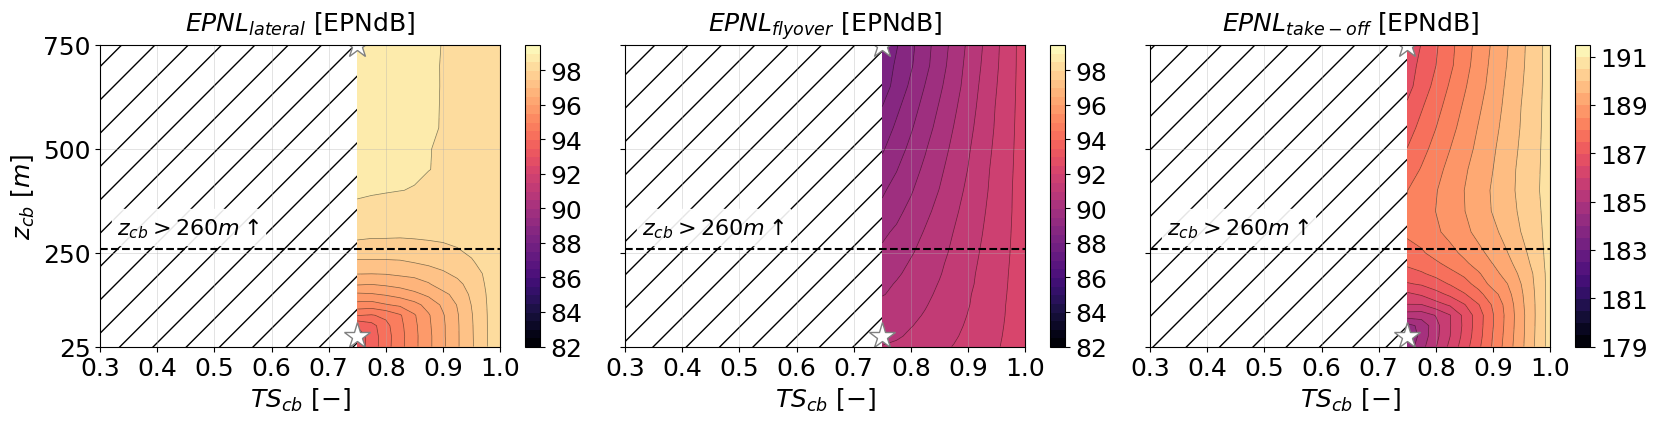

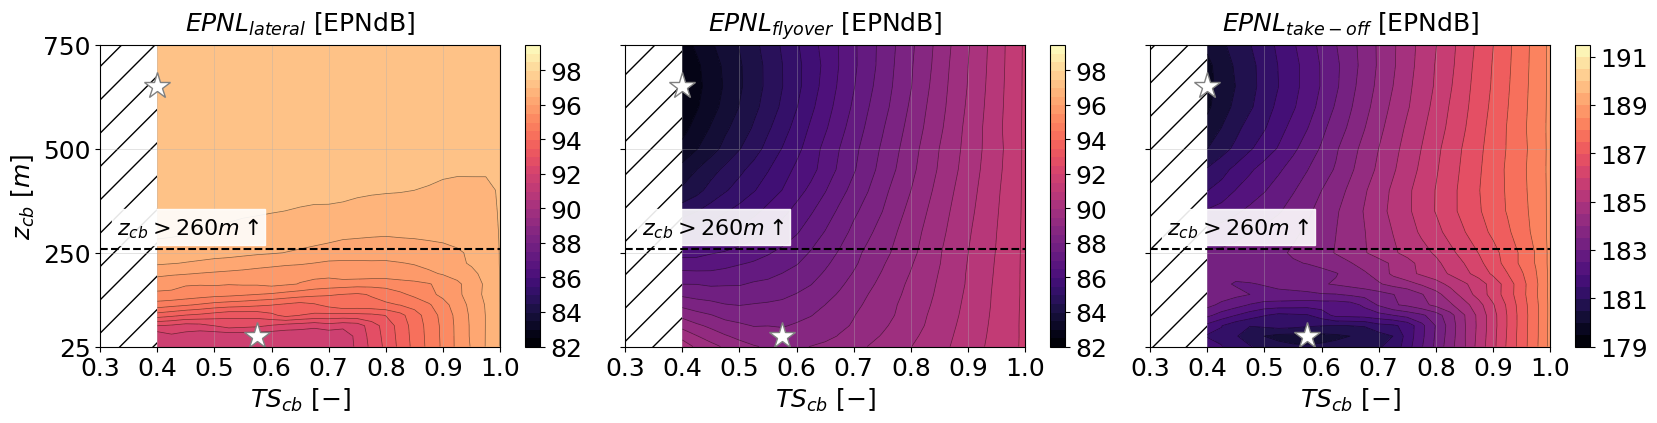

In [22]:
plot_stcb_design_sweep('stca', z_cb_lst, TS_cb_lst['stca']['V2'], epnl_lateral['stca']['V2'], epnl_flyover['stca']['V2'], epnl_lateral['stca']['Vmax'], epnl_flyover['stca']['Vmax'])
plot_stcb_design_sweep('stca', z_cb_lst, TS_cb_lst['stca']['Vmax'], epnl_lateral['stca']['Vmax'], epnl_flyover['stca']['Vmax'], epnl_lateral['stca']['V2'], epnl_flyover['stca']['V2'])

### GT Medium SST

EPNL constraint:  95.02854010673747
EPNL constraint:  94.25845755290233


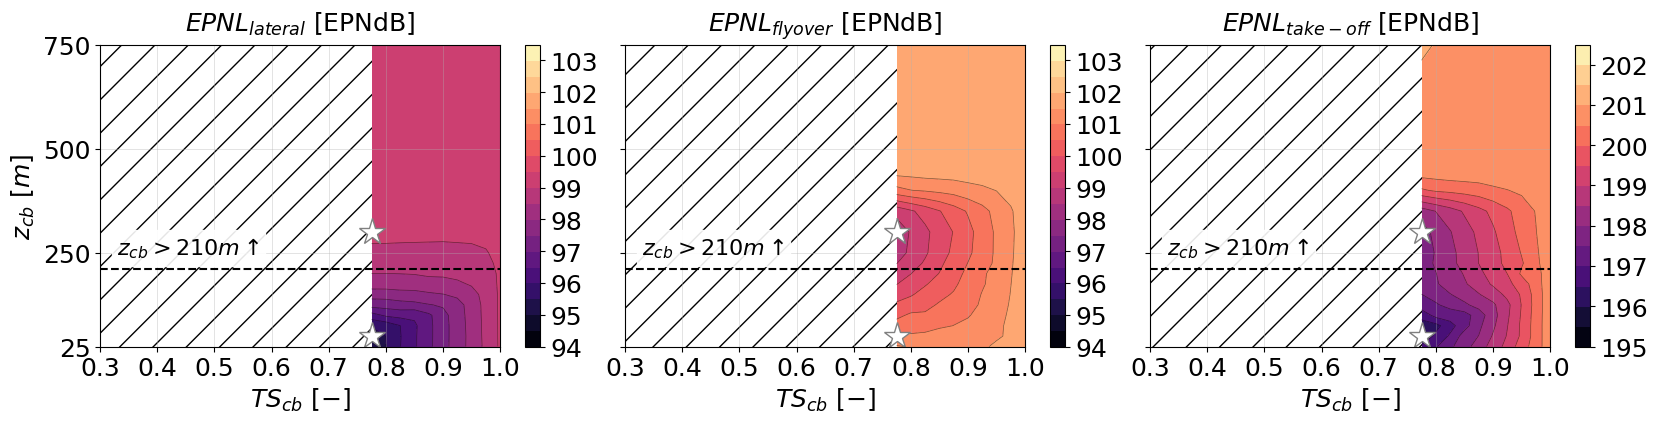

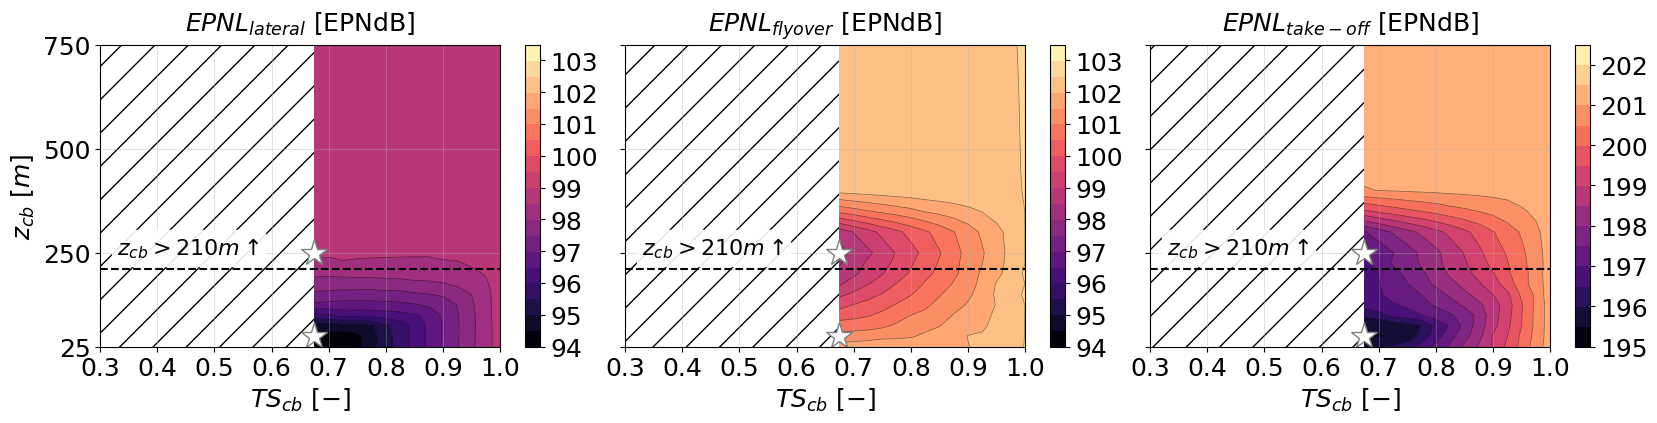

In [23]:
plot_stcb_design_sweep('a10', z_cb_lst, TS_cb_lst['a10']['V2'], epnl_lateral['a10']['V2'], epnl_flyover['a10']['V2'], epnl_lateral['a10']['Vmax'], epnl_flyover['a10']['Vmax'])
plot_stcb_design_sweep('a10', z_cb_lst, TS_cb_lst['a10']['Vmax'], epnl_lateral['a10']['Vmax'], epnl_flyover['a10']['Vmax'], epnl_lateral['a10']['V2'], epnl_flyover['a10']['V2'])

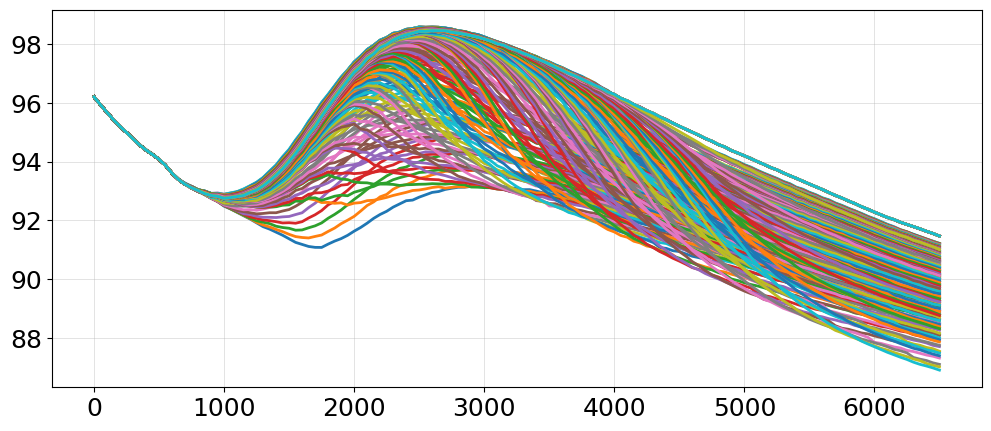

In [16]:
for i in np.arange(np.shape(epnl_sideline['stca']['V2'])[0]):
    for j in np.arange(np.shape(epnl_sideline['stca']['V2'])[1]):
        plt.plot(np.linspace(0, 6500, 131), epnl_sideline['stca']['V2'][i,j,:])

In [57]:
np.linspace(3000, 6500, 17)

array([3000.  , 3218.75, 3437.5 , 3656.25, 3875.  , 4093.75, 4312.5 ,
       4531.25, 4750.  , 4968.75, 5187.5 , 5406.25, 5625.  , 5843.75,
       6062.5 , 6281.25, 6500.  ])